In [17]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [18]:
train_file_path = "D:/Downloads/train-data.tsv"
test_file_path = "D:/Downloads/valid-data.tsv"

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [19]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [20]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [21]:
train_df.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [23]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [24]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [25]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

In [26]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [27]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [28]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 74s 1s/step - loss: 0.6797 - accuracy: 0.8657 - val_loss: 0.6604 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 52s 1s/step - loss: 0.6225 - accuracy: 0.8657 - val_loss: 0.5687 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 53s 1s/step - loss: 0.5181 - accuracy: 0.8657 - val_loss: 0.4883 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 53s 1s/step - loss: 0.4527 - accuracy: 0.8657 - val_loss: 0.4146 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 58s 1s/step - loss: 0.3666 - accuracy: 0.8657 - val_loss: 0.3071 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 57s 1s/step - loss: 0.2452 - accuracy: 0.8657 - val_loss: 0.1798 - val_accuracy: 0.8604
Epoch 7/10
44/44 [==============================] - 60s 1s/step - loss: 0.1574 - accuracy: 0.9109 - val_loss: 0.1245 - val_accuracy: 0.9667
Epoch 8/10
44/44 [==

(0.0, 0.711064031533897)

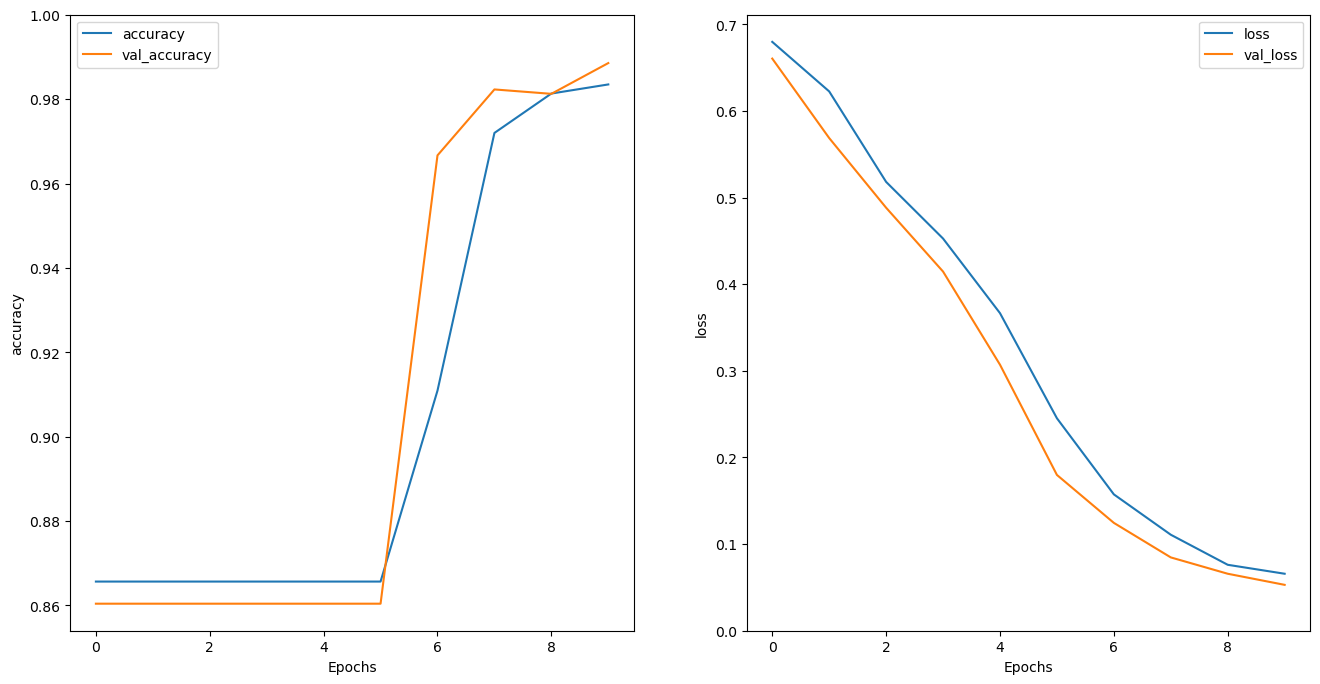

In [29]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [30]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6797252297401428, 0.622528076171875, 0.5180917382240295, 0.45268675684928894, 0.36657172441482544, 0.24523954093456268, 0.15738563239574432, 0.11080969870090485, 0.07610525190830231, 0.06577223539352417]
[0.6604307889938354, 0.5686957240104675, 0.48826324939727783, 0.41457945108413696, 0.30707377195358276, 0.17982879281044006, 0.12448852509260178, 0.08462198078632355, 0.06577253341674805, 0.052949193865060806]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.9109195470809937, 0.9719827771186829, 0.9813218116760254, 0.983476996421814]
[0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.9666666388511658, 0.9822916388511658, 0.981249988079071, 0.9885416626930237]


In [31]:
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 6s 6s/step
[[-3.763696]]
[-3.763696, 'ham']
